### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

from YearPlotter import YearPlotter
import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBSSBB'
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12884
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[20 50 40 4C 80 4...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[00 00 A0 D3 00 0...|1927.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[80 4D 80 D4 E0 D...|1928.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     1|[00 53 00 00 00 C...|1929.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     2|[E0 54 E0 55 00 4...|1930.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
STAT_Descriptions

[('SortedVals',
  'Sample of values',
  'vector whose length varies between measurements'),
 ('UnDef',
  'sample of number of undefs per row',
  'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))]

### Select data for a particular station and measurement type

In [3]:
# Filtering through to see which station to use
sqlContext.registerDataFrameAsTable(df,'weather')

Query="SELECT station,count(distinct year), sum(undefs) as undefs "\
      "FROM weather group by station having sum(undefs) < 1000 "\
      "and count(distinct year)>50 "\
      "and count(distinct measurement) = 6 "\
      "order by undefs"
print Query
df1 = sqlContext.sql(Query)
print df1.show()

SELECT station,count(distinct year), sum(undefs) as undefs FROM weather group by station having sum(undefs) < 1000 and count(distinct year)>50 and count(distinct measurement) = 6 order by undefs
+-----------+--------------------+------+
|    station|count(DISTINCT year)|undefs|
+-----------+--------------------+------+
|USC00306062|                  67|   655|
|USC00303851|                  87|   737|
|USC00306314|                  86|   968|
|USC00305925|                  59|   984|
+-----------+--------------------+------+

None


In [4]:
# Let's pick a station for our study
station = 'USC00306314' # Oswego

sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX',station)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TX=np.vstack(rows)
TX=TX/10.  # scaling to make the temperature be in centingrates
shape(TX)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00306314'
86 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[20 50 40 4C 80 4...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMAX|USC00306314|     0|[00 00 A0 D3 00 0...|1927.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(86, 365)

In [5]:
# let's get TMIN
Query="SELECT * FROM weather "\
      "WHERE measurement='%s' and station='%s'"%('TMIN',station)

dfn = sqlContext.sql(Query)
print dfn.count(),'rows'
dfn.show(2)
rows=dfn.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
TN=np.vstack(rows)
TN=TN/10.  # scaling to make the temperature be in centigrades
shape(TN)

86 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       TMIN|USC00306314|     0|[00 D3 80 C9 20 D...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       TMIN|USC00306314|     0|[E0 D5 28 D8 30 D...|1927.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(86, 365)

#### The elevation gathered here is very close to what's shown in [US Climate Data](http://www.usclimatedata.com/climate/old-forge/new-york/united-states/usny1061)

In [6]:
Query="SELECT longitude, latitude FROM weather where station='{0}' limit 1".format(station)

df1l = sqlContext.sql(Query)
print 'Oswego Longitude, Latitude'
df1l.show()

Oswego Longitude, Latitude
+---------+--------+
|longitude|latitude|
+---------+--------+
| -76.4933| 43.4622|
+---------+--------+



### Script for plotting yearly plots

In [7]:
Query="SELECT * FROM weather "\
      "WHERE measurement='%s' and station='%s'"%('PRCP',station)

dfp = sqlContext.sql(Query)
print dfp.count(),'rows'
dfp.show(2)
rows=dfp.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
PR=np.vstack(rows)
PR=PR/10.
shape(PR)

86 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    106.7| 43.4622| -76.4933|       PRCP|USC00306314|     0|[00 00 00 45 00 0...|1926.0|BBBBSSBB|
|    106.7| 43.4622| -76.4933|       PRCP|USC00306314|     0|[00 49 00 00 00 0...|1927.0|BBBBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(86, 365)

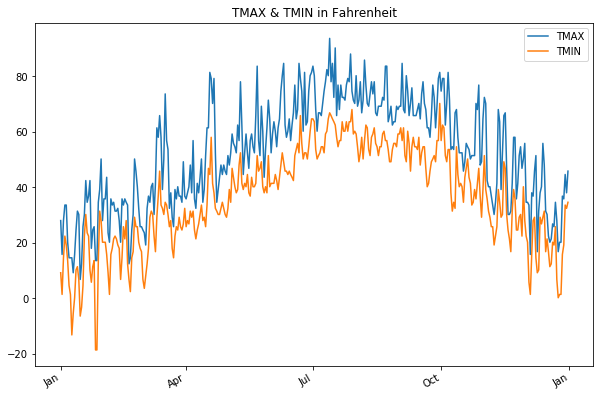

In [8]:
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(TX[1:2,:].transpose()*2-4+32,fig,ax,labels=['TMAX'])
YP.plot(TN[1:2,:].transpose()*2-4+32,fig,ax,labels=['TMIN'],title='TMAX & TMIN in Fahrenheit')

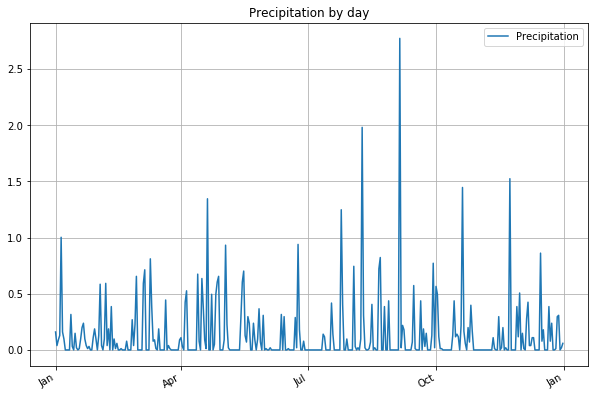

In [9]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(PR[-1:,:].transpose()*.039,fig,ax,labels=['Precipitation'],title='Precipitation by day')

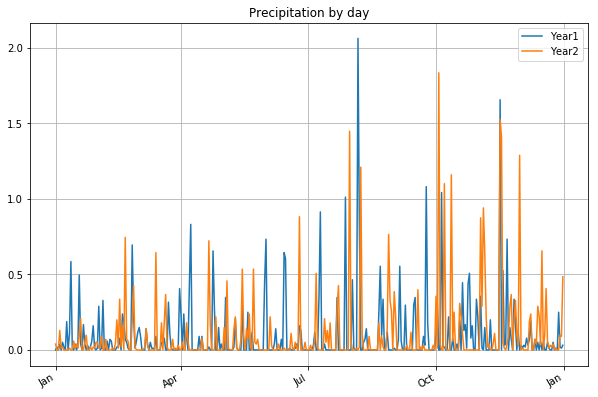

In [10]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(PR[:2,:].transpose()*.039,fig,ax,title='Precipitation by day',labels=['Year1','Year2'])

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [11]:
def plot_pair(pair,func,c=0,labels=None):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis,c,labels)
        
def plot_valid(m,fig,axis,c,labels=None):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title=m+' valid-counts',label=labels)

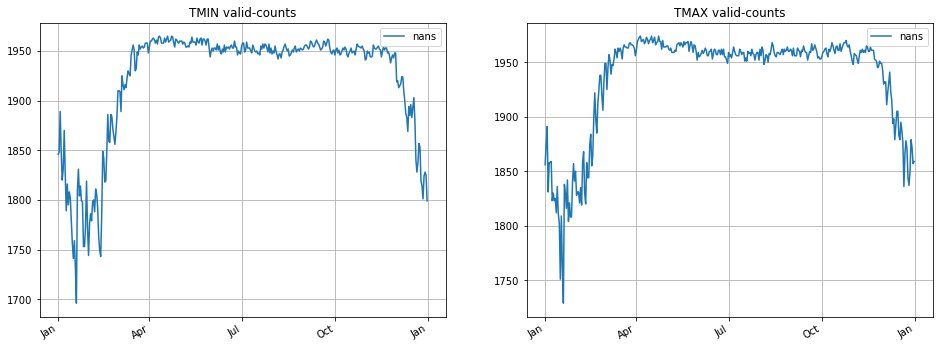

In [12]:
plot_pair(['TMIN','TMAX'],plot_valid,0,'nans')

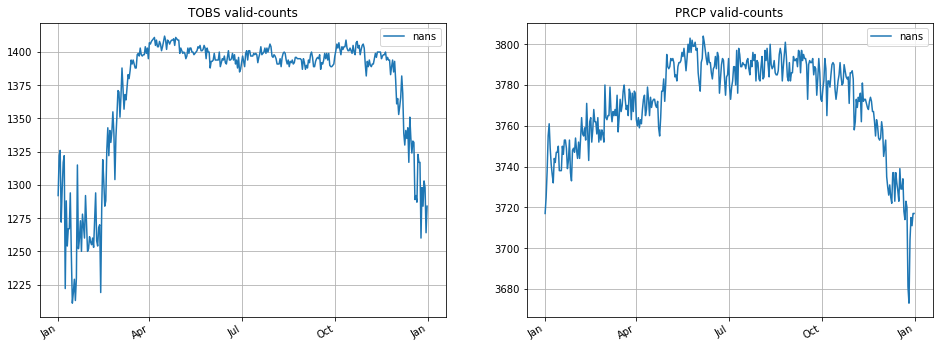

In [13]:
plot_pair(['TOBS','PRCP'],plot_valid,0,'nans')

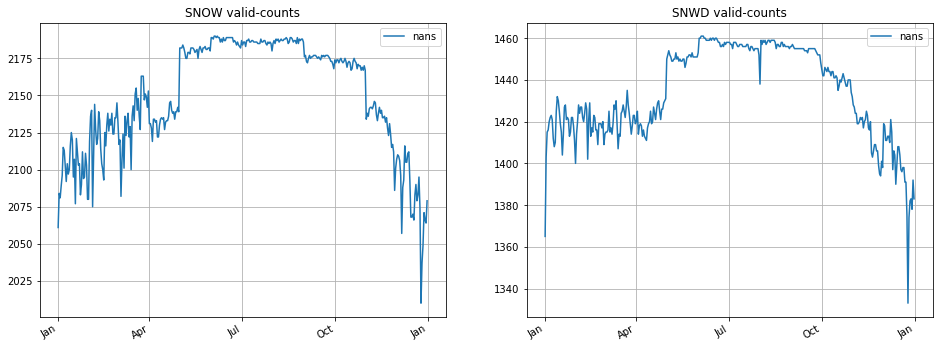

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_valid,0,'nans')

### Plots of mean and std of observations

In [15]:
def plot_mean_std(m,fig,axis,c,labels=None):
    mean=STAT[m]['Mean']/10.
    std=np.sqrt(STAT[m]['Var'])/10.

    if m == 'SNOW' or m == 'SNWD':
        mean=STAT[m]['Mean']
        std=np.sqrt(STAT[m]['Var'])
    
    elif m == 'TMIN' or m == 'TMAX':
        mean=STAT[m]['Mean']/10.*2-4+32
        std=np.sqrt(STAT[m]['Var'])/10.*2-4+32

    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title=m+' Mean+-std',labels=labels)

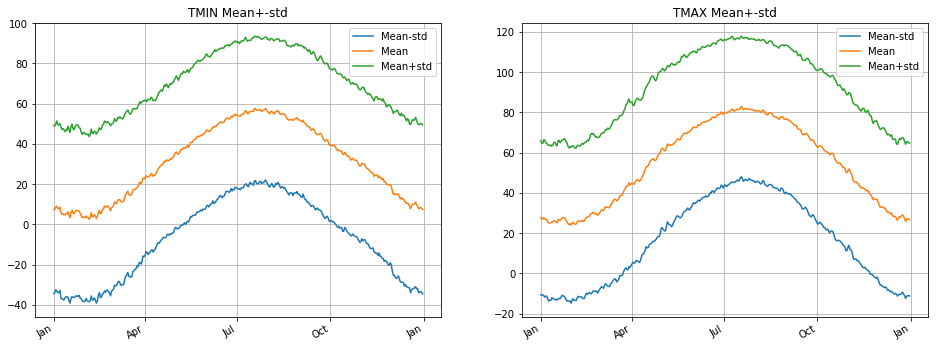

In [16]:
plot_pair(['TMIN','TMAX'],plot_mean_std,0,['Mean-std','Mean','Mean+std'])

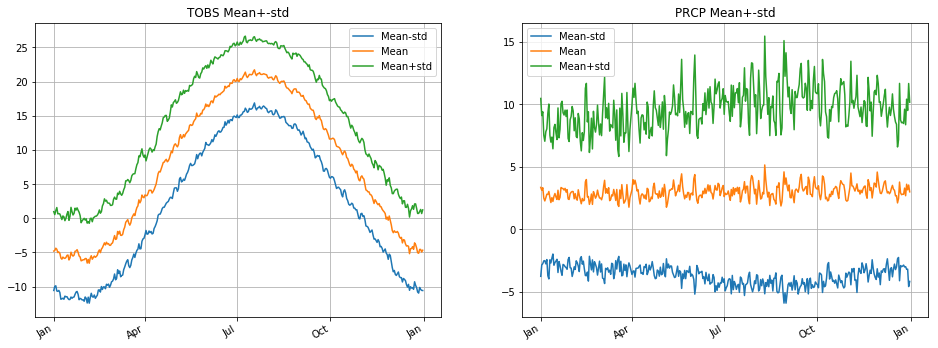

In [17]:
plot_pair(['TOBS','PRCP'],plot_mean_std,0,['Mean-std','Mean','Mean+std'])

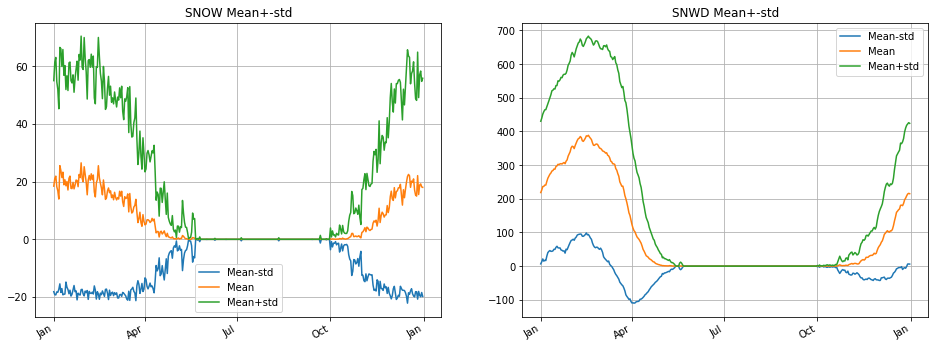

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std,0,['Mean-std','Mean','Mean+std'])

In [19]:
def plot_mean(m,fig,axis,label):
    mean=STAT[m]['Mean']/10.0
    if m == 'TOBS':
        mean=STAT[m]['Mean']/10.0*2-4+32
    YP.plot(mean,fig,axis,title=m+' Mean',label=label)

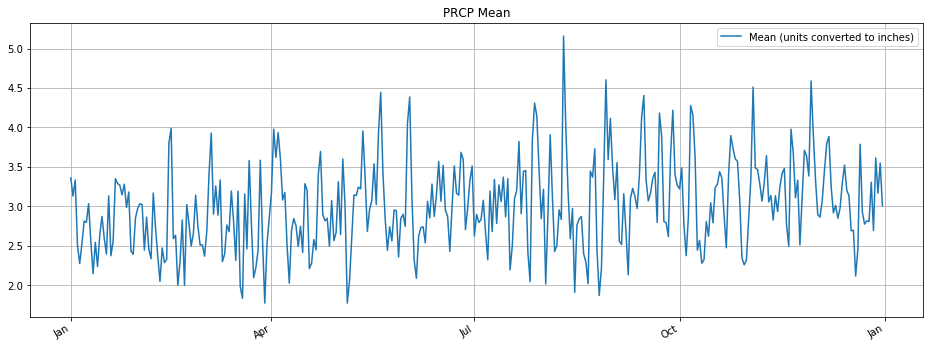

In [20]:
fig,X=subplots(1,1,figsize=(16,6))
plot_mean('PRCP',fig,X,'Mean (units converted to inches)')

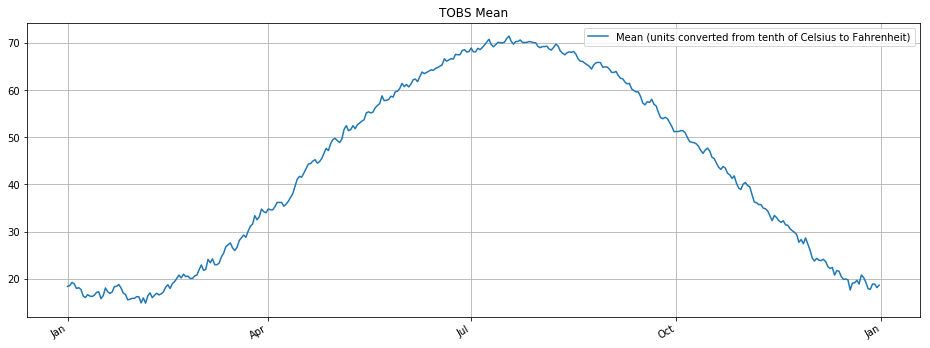

In [21]:
fig,X=subplots(1,1,figsize=(16,6))
plot_mean('TOBS',fig,X,'Mean (units converted from tenth of Celsius to Fahrenheit)')

#### plotting top 3 eigenvectors

In [22]:
def plot_eigen(m,fig,axis,c=3,labels=None):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:c],fig,axis,title=m+' Top Eigenvectors',labels=labels)

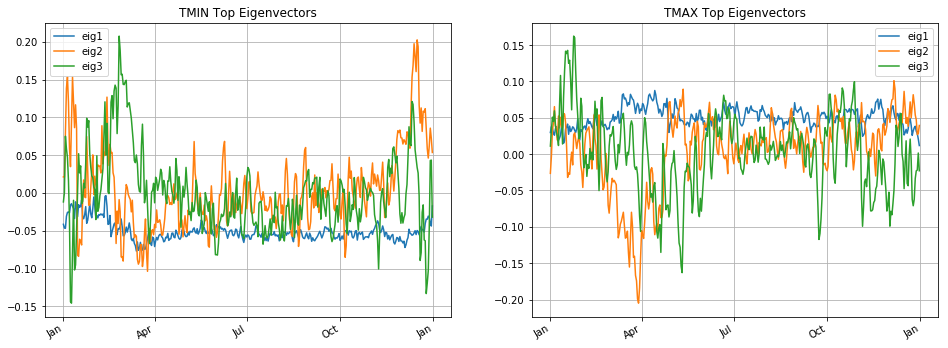

In [23]:
plot_pair(['TMIN','TMAX'],plot_eigen,3,['eig1','eig2','eig3'])

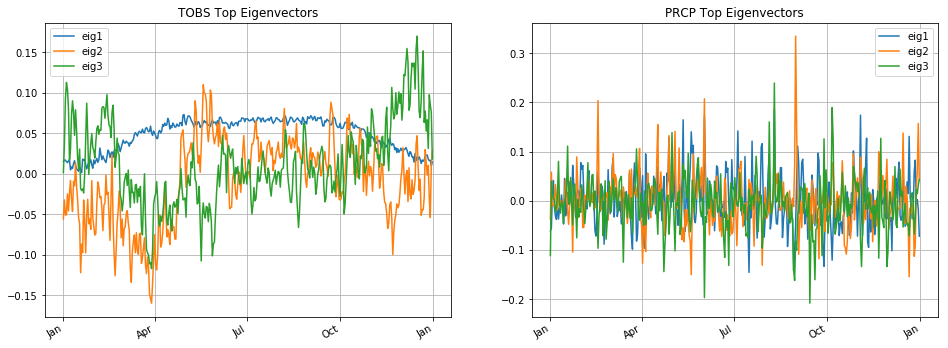

In [24]:
plot_pair(['TOBS','PRCP'],plot_eigen,3,['eig1','eig2','eig3'])

#### plotting top 4 eigenvectors

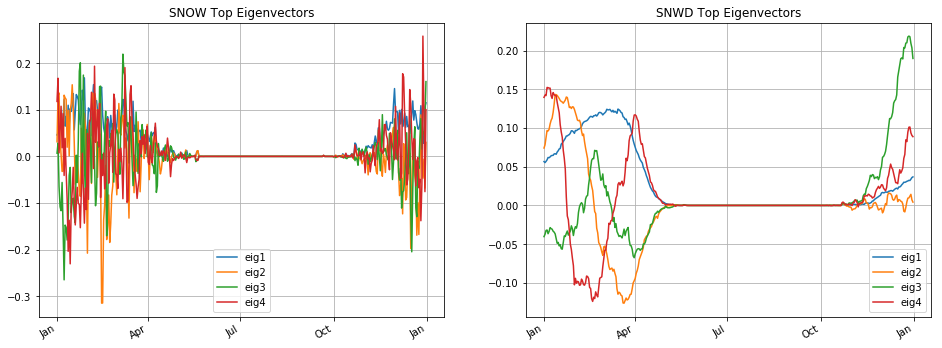

In [25]:
plot_pair(['SNOW', 'SNWD'],plot_eigen,4,['eig1','eig2','eig3','eig4'])

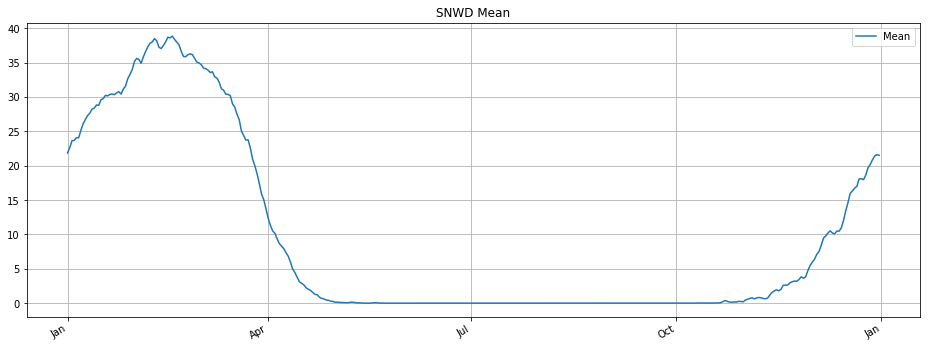

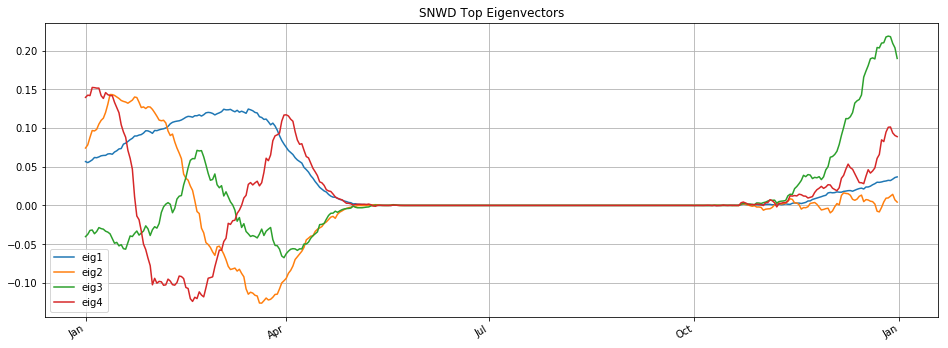

In [26]:
fig,X=subplots(1,1,figsize=(16,6))
plot_mean('SNWD',fig,X,'Mean')
fig,X=subplots(1,1,figsize=(16,6))
plot_eigen('SNWD',fig,X,4,['eig1','eig2','eig3','eig4'])

### Script for plotting percentage of variance explained

In [27]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

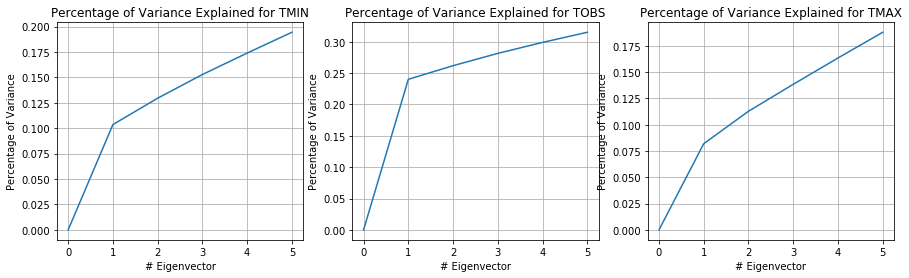

In [28]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']:
    pltVarExplained(j)
    j+=1

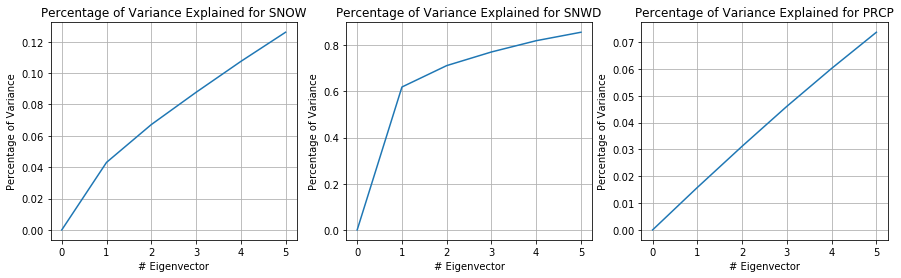

In [29]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [30]:
#sc.stop()